In [1]:
options(warn=-1)
library(cowplot);library(ggpubr)
#library(patchwork)

library(dplyr);library(tidyverse)
library(data.table);library(Matrix)
library(magrittr)

library(viridis);library(tibble)
library(scales)
library(ggrepel);library(forcats)

library(Seurat);library(SingleCellExperiment)
library(parallel)
memory.limit(size = 98226*1024)
library(indRop)
library(scDblFinder)
# Pass TRUE if you want to see progress output on some of Monocle 3's operations
DelayedArray:::set_verbose_block_processing(TRUE)

# Passing a higher value will make some computations faster but use more memory. Adjust with caution!
options(DelayedArray.block.size=1000e6)

base::gc()
base::rm(list = ls()) # Clear the environment
GSE118918.marker <- c(
"Pdgfra","Vcan","Olig1","Ptprz1","Olig2", # opc
"Plp1","Cldn11","Cnp","Tspan2","Mobp", 
"Trf","Apod","Ermn","Car2",
"Ptgds","Plp1","Mal","Cryab","Car2", # 
"Fyn","Sirt2","Tuba1a","Bcas1","Enpp6", # cop
"Hexb","Ctss","C1qb","C1qc","Cx3cr1", # micro
"Lyz2","Mrc1","Pf4","Ctsb","F13a1", # macrophage
"Ly6c1","Ly6a","Flt1","Itm2a","Slco1a4", # Endothelial
"Rgs5","Acta2","Myl9","Tagln","Cald1", # Mural
"Dcn","Col1a2","Igf2","Igfbp2","Pcolce",#VLMC
"Ccdc153","Rarres2","Tmem212","Nnat","Rsph1", # Ependyma    
"Cpe","Apoe","Cst3","Mt1","Dbi","Aldoc","Gja1","Slc1a2","Slc1a3","Clu", 
"Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
"Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    
"Sst","Npy","Resp18","Nap1l5","Nos1", # NEURON
"Lypd1","Meg3","Atp1b1","Snhg11","Olfm1",# NEURON
"Penk","Arpp21","Ppp3ca","Atp2b1","Hpca" #NEURON
)

oligo.mark <- c("Sirt2","Bmp4","Tnr","Fyn", "Enpp6", "Neu4",  # COP 
                  "C1ql1", "Olig1", "Pdgfra", "Cspg4",# OPC
                  "Apod", "Trf", "Plp1", "Mbp", "Fth1","Mag", "Mog","Cldn11","Mobp", # MOL
                  "Tmeff2","Idh1","Neu4", "Cdh20", "Tmem163", "Nfasc", "Mpzl1", # NFOL
                  "Mal","Opalin", "Ptgds","Bfsp2" #MFOL
                 )

setwd('~/R')
source('~/R/single_cell_function_20220408.R')

Loading required package: ggplot2


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching 

[1] Inf

[1] FALSE

used     (Mb)  gc trigger (Mb)  max used (Mb) 
Ncells 10341880 552.4 17292347   923.6 13104381 699.9
Vcells 17551365 134.0 25947558   198.0 21556299 164.5

Loading required package: httr


Attaching package: ‘httr’


The following object is masked from ‘package:Biobase’:

    content


Loading required package: nichenetr



In [3]:
library(readxl)

sheet1 <- c("NSC","NPC", "OPC", "COP", "MFOL", 
           "MICRO", "CD45", "PERICYTE", "INTERNEURON")
gene1 <- GSE106447.MARKER.ALL <- list()
for(i in seq(1:9)){
    temp1 <-  read_excel(paste0(file.path("/home","choelab","working","public_dataset","GSE106447"),"/GSE106447.xlsx"), col_names=T, sheet = i)
    gene1[[i]] <- temp1$`GENE ID`[1:5]
    GSE106447.MARKER.ALL[[i]] <-  temp1$`GENE ID`
}    
GSE106447.MARKER <- unique(unlist(gene1))
names(GSE106447.MARKER.ALL) <- sheet1

# SMCs, smooth muscle cells; PVMs, perivascular macrophages; MSNs, medium spiny neurons,
sheet <- c("Endothelial_Cells","Pericyte", "SMC", "Microglia", "PVM", 
           "Ependymal", "MSN1", "MSN2", "COP", "MOL",
           "MFOL2", "MFOL1", "Neuroblast", "TAP", "OPC", 
           "Astrocyte", "NSC")
gene <- GSE111527.MARKER.ALL <- list()
for(i in seq(1:17)){
    temp <-  read_excel(paste0(file.path("/home","choelab","working","public_dataset","GSE111527"),"/GSE111527MARKER.xlsx"), col_names=T, sheet = i)
    gene[[i]] <- temp$gene[1:5]
    GSE111527.MARKER.ALL[[i]] <- temp$gene
}    
GSE111527.MARKER <- unique(unlist(gene))
names(GSE111527.MARKER.ALL) <- sheet


In [4]:
pathIMZ <- file.path("/home","choelab","working","OL_sorted","reference","GSE180041")
fileListCNTs <- list.files(pathIMZ, pattern = "GSE180041_exonic_umi.csv.gz")
# fileListCNTs <- list.files(pathIMZ, pattern = "GSE180041_exonic_norm_umi.csv.gz")
path_in_counts.raw <- paste0(pathIMZ,"/",fileListCNTs)
raw <- read.table(path_in_counts.raw, header =T, sep=",")

In [12]:
raw[1:10,1:2]

CELL6146508 CELL6146509
1  0           2          
2  0           0          
3  0           0          
4  0           0          
5  0           0          
6  0           0          
7  2           2          
8  0           1          
9  5           6          
10 0           0

In [17]:
pathIMZ <- file.path("/home","choelab","working","OL_sorted","reference","GSE180041")
fileListCNTs <- list.files(pathIMZ, pattern = "GSE180041_tsne_coordinates_and_cluster_labels_microglia_cells.csv.gz")
# fileListCNTs <- list.files(pathIMZ, pattern = "GSE180041_exonic_norm_umi.csv.gz")
path_in_counts.raw <- paste0(pathIMZ,"/",fileListCNTs)
raw2 <- read.table(path_in_counts.raw, header =T, sep=",")

In [18]:
raw2

TPL2 TauP301S seurat_cluster TSNE1       TSNE2       
1     WT   Positive C23             24.2212793 -15.003632  
2     WT   Positive C11             18.6837042  12.576865  
3     WT   Positive C22             -7.2848529  23.669773  
4     WT   Positive C22             -6.0024329  24.065056  
5     WT   Positive C11             14.9536616  20.452003  
6     WT   Positive C8               2.9877533  30.166430  
7     WT   Positive C8               9.1887122  22.338806  
8     WT   Positive C8              16.4278325  20.166406  
9     WT   Positive C1               3.8312991   1.173740  
10    WT   Positive C6             -14.5198581  17.670616  
11    WT   Positive C11             13.3683706  19.352420  
12    WT   Positive C11             20.1530263  14.835437  
13    WT   Positive C12             16.4233108   9.031291  
14    WT   Positive C2               0.5275555   9.944045  
15    WT   Positive C12             23.5642920   6.411373  
16    WT   Positive C8              10.1317306  21.349049  
17    WT   Positive C5              -8.8529424  14.870141  
18    WT   Positive C18              5.9147194  18.337158  
19    WT   Positive C2             -12.0918595  14.060750  
20    WT   Positive C2               8.1673612  13.169983  
21    WT   Positive C5              -2.3710630  13.828285  
22    WT   Positive C8               6.5153385  29.551898  
23    WT   Positive C8               9.2996607  23.633058  
24    WT   Positive C6              14.2777145   8.663337  
25    WT   Positive C17            -28.9365722   7.425800  
26    WT   Positive C2              -1.0494023  13.006421  
27    WT   Positive C8               2.9178428  29.162895  
28    WT   Positive C8              11.1656786  24.513310  
29    WT   Positive C5              -0.4766041  25.953986  
30    WT   Positive C6             -14.0833886  18.833890  
⋮     ⋮    ⋮        ⋮              ⋮           ⋮           
54494 WT   Positive C5              -7.0418692  10.14761103
54495 WT   Positive C1              21.7947688  -1.10232255
54496 WT   Positive C1               9.3595078  -0.11835251
54497 WT   Positive C2               0.6994115   8.42393893
54498 WT   Positive C17            -24.9408673   1.09897702
54499 WT   Positive C0             -14.7600689  -9.70105065
54500 WT   Positive C17            -27.6768424   3.62660789
54501 WT   Positive C1              22.0391487   3.26322989
54502 WT   Positive C15            -22.5327938  17.91742628
54503 WT   Positive C15            -21.3518231  17.22833635
54504 WT   Positive C15            -22.2482695  16.91274982
54505 WT   Positive C15            -19.5090044  18.94306339
54506 WT   Positive C13             -4.3966698  -1.20366985
54507 WT   Positive C0              -2.4205940  -3.10980039
54508 WT   Positive C0              -1.0442609   0.05756342
54509 WT   Positive C15            -22.5556177  17.17244270
54510 WT   Positive C13             -7.7737174   1.10260251
54511 WT   Positive C8              10.3172745  24.24333615
54512 WT   Positive C3              -7.1758439 -29.57443535
54513 WT   Positive C1               8.5228983   1.07781364
54514 WT   Positive C15            -22.3699398  17.88299311
54515 WT   Positive C0              -4.7948115   2.19525456
54516 WT   Positive C1              11.3740608  -5.89999638
54517 WT   Positive C1              -6.9277233   4.99282330
54518 WT   Positive C0              -7.0703323  -2.90224951
54519 WT   Positive C8               0.6694625  21.82028313
54520 WT   Positive C8               1.4635485  24.90530179
54521 WT   Positive C13             -6.5362382   0.69514051
54522 WT   Positive C0              10.0917932   0.23922932
54523 WT   Positive C15            -30.7935241   0.27717012
      cluster_interpretation         
1     Neutrophils                    
2     HighDAM                        
3     HighDAM/High-MHCII             
4     HighDAM/High-MHCII             
5     HighDAM                        
6     IFN-response/HighDAM           
7     HighDAM       

In [48]:
path_in_counts.raw <- paste0(pathIMZ,"/",fileListCNTs)
raw <- read.csv(path_in_counts.raw, header = TRUE)

In [52]:
colnames(raw)

[1] "0"                 "0"                 "0"                
    [4] "0"                 "0"                 "0"                
    [7] "0.286756109781217" "0"                 "0.716890274453042"
   [10] "0"                 "1.29040249401548"  "0"                
   [13] "0"                 "0"                 "0"                
   [16] "0"                 "0"                 "0.143378054890608"
   [19] "0.286756109781217" "0"                 "0"                
   [22] "0"                 "0.430134164671825" "0"                
   [25] "0"                 "0.143378054890608" "0"                
   [28] "0"                 "0.716890274453042" "0"                
   [31] "0"                 "0.286756109781217" "0.143378054890608"
   [34] "0"                 "0"                 "0"                
   [37] "0"                 "0"                 "0"                
   [40] "0"                 "0.143378054890608" "0"                
   [43] "0"                 "0.430134164671825" "0"                
   [46] "0"                 "0"                 "0"                
   [49] "0.143378054890608" "0"                 "1.43378054890608" 
   [52] "0.143378054890608" "0"                 "0"                
   [55] "0"                 "0"                 "0"                
   [58] "0"                 "0"                 "0"                
   [61] "0"                 "0.573512219562434" "0"                
   [64] "0.143378054890608" "1.00364638423426"  "0.716890274453042"
   [67] "0"                 "0"                 "0.143378054890608"
   [70] "0.143378054890608" "0"                 "0"                
   [73] "0"                 "0"                 "0"                
   [76] "0"                 "0.716890274453042" "0"                
   [79] "0"                 "0"                 "0"                
   [82] "0.573512219562434" "0"                 "0"                
   [85] "0"                 "0.286756109781217" "0.716890274453042"
   [88] "0.573512219562434" "0.143378054890608" "0"                
   [91] "0"                 "0"                 "0"                
   [94] "0"                 "0.143378054890608" "0"                
   [97] "0"                 "0"                 "2.00729276846852" 
  [100] "0"                 "0.860268329343651" "0"                
  [103] "0.430134164671825" "1.57715860379669"  "0.143378054890608"
  [106] "0.860268329343651" "0"                 "0"                
  [109] "0"                 "0.573512219562434" "0"                
  [112] "0"                 "0"                 "18.7825251906697" 
  [115] "0"                 "0"                 "0.286756109781217"
  [118] "0"                 "0"                 "0.143378054890608"
  [121] "0"                 "0"                 "0"                
  [124] "0"                 "0"                 "0.143378054890608"
  [127] "0"                 "0.716890274453042" "0.286756109781217"
  [130] "0"                 "0"                 "0"                
  [133] "0"                 "0.143378054890608" "0.286756109781217"
  [136] "0.573512219562434" "0"                 "0"                
  [139] "0"                 "0"                 "0"                
  [142] "0"                 "0.286756109781217" "0"                
  [145] "0.573512219562434" "0"                 "0"                
  [148] "0"                 "0"                 "0"                
  [151] "0"                 "0"                 "0"                
  [154] "0"                 "0.430134164671825" "0"                
  [157] "0"                 "0.143378054890608" "0"                
  [160] "0"                 "0"                 "0"                
  [163] "0"                 "0.143378054890608" "0"                
  [166] "0"                 "7.31228079942103"  "0"                
  [169] "0"                 "0"                 "0"                
  [172] "0"                 "0.430134164671825" "0"                
  [175] "0"                 "1.86391471357791"  "0"         

In [20]:

GSE180041.raw <- CreateSeuratObject(counts = raw, min.cells = 0)

In [39]:

GSE180041.meta <- read.table(paste0(pathIMZ,"/",list.files(pathIMZ, pattern = "GSE180041_tsne_coordinates_and_cluster_labels_all_cells.csv")), header =T, sep=",")

In [ ]:
GSE180041.meta

In [27]:
colnames(GSE180041.raw)

[1] "0"       "0.1"     "0.2"     "0.3"     "0.4"     "0.5"     "2"      
    [8] "0.6"     "5"       "0.7"     "9"       "0.8"     "0.9"     "0.10"   
   [15] "0.11"    "0.12"    "0.13"    "1"       "2.1"     "0.14"    "0.15"   
   [22] "0.16"    "3"       "0.17"    "0.18"    "1.1"     "0.19"    "0.20"   
   [29] "5.1"     "0.21"    "0.22"    "2.2"     "1.2"     "0.23"    "0.24"   
   [36] "0.25"    "0.26"    "0.27"    "0.28"    "0.29"    "1.3"     "0.30"   
   [43] "0.31"    "3.1"     "0.32"    "0.33"    "0.34"    "0.35"    "1.4"    
   [50] "0.36"    "10"      "1.5"     "0.37"    "0.38"    "0.39"    "0.40"   
   [57] "0.41"    "0.42"    "0.43"    "0.44"    "0.45"    "4"       "0.46"   
   [64] "1.6"     "7"       "5.2"     "0.47"    "0.48"    "1.7"     "1.8"    
   [71] "0.49"    "0.50"    "0.51"    "0.52"    "0.53"    "0.54"    "5.3"    
   [78] "0.55"    "0.56"    "0.57"    "0.58"    "4.1"     "0.59"    "0.60"   
   [85] "0.61"    "2.3"     "5.4"     "4.2"     "1.9"     "0.62"    "0.63"   
   [92] "0.64"    "0.65"    "0.66"    "1.10"    "0.67"    "0.68"    "0.69"   
   [99] "14"      "0.70"    "6"       "0.71"    "3.2"     "11"      "1.11"   
  [106] "6.1"     "0.72"    "0.73"    "0.74"    "4.3"     "0.75"    "0.76"   
  [113] "0.77"    "131"     "0.78"    "0.79"    "2.4"     "0.80"    "0.81"   
  [120] "1.12"    "0.82"    "0.83"    "0.84"    "0.85"    "0.86"    "1.13"   
  [127] "0.87"    "5.5"     "2.5"     "0.88"    "0.89"    "0.90"    "0.91"   
  [134] "1.14"    "2.6"     "4.4"     "0.92"    "0.93"    "0.94"    "0.95"   
  [141] "0.96"    "0.97"    "2.7"     "0.98"    "4.5"     "0.99"    "0.100"  
  [148] "0.101"   "0.102"   "0.103"   "0.104"   "0.105"   "0.106"   "0.107"  
  [155] "3.3"     "0.108"   "0.109"   "1.15"    "0.110"   "0.111"   "0.112"  
  [162] "0.113"   "0.114"   "1.16"    "0.115"   "0.116"   "51"      "0.117"  
  [169] "0.118"   "0.119"   "0.120"   "0.121"   "3.4"     "0.122"   "0.123"  
  [176] "13"      "0.124"   "0.125"   "1.17"    "0.126"   "0.127"   "2.8"    
  [183] "0.128"   "1.18"    "3.5"     "0.129"   "0.130"   "0.131"   "0.132"  
  [190] "2.9"     "0.133"   "2.10"    "0.134"   "0.135"   "1.19"    "0.136"  
  [197] "0.137"   "10.1"    "2.11"    "0.138"   "0.139"   "0.140"   "0.141"  
  [204] "1.20"    "1.21"    "2.12"    "0.142"   "0.143"   "1.22"    "2.13"   
  [211] "0.144"   "0.145"   "0.146"   "23"      "2.14"    "0.147"   "0.148"  
  [218] "0.149"   "0.150"   "0.151"   "0.152"   "3.6"     "3.7"     "0.153"  
  [225] "12"      "0.154"   "2.15"    "1.23"    "0.155"   "41"      "0.156"  
  [232] "0.157"   "2.16"    "0.158"   "0.159"   "0.160"   "0.161"   "0.162"  
  [239] "0.163"   "0.164"   "1.24"    "3.8"     "0.165"   "0.166"   "4.6"    
  [246] "5.6"     "3.9"     "0.167"   "5.7"     "0.168"   "0.169"   "1.25"   
  [253] "1.26"    "1.27"    "1.28"    "2.17"    "8"       "1.29"    "0.170"  
  [260] "0.171"   "0.172"   "0.173"   "0.174"   "0.175"   "0.176"   "0.177"  
  [267] "0.178"   "0.179"   "0.180"   "0.181"   "0.182"   "0.183"   "1.30"   
  [274] "10.2"    "2.18"    "1.31"    "0.184"   "0.185"   "0.186"   "0.187"  
  [281] "0.188"   "0.189"   "0.190"   "0.191"   "0.192"   "3.10"    "0.193"  
  [288] "1.32"    "0.194"   "0.195"   "0.196"   "0.197"   "0.198"   "0.199"  
  [295] "0.200"   "5.8"     "0.201"   "0.202"   "0.203"   "4.7"     "4.8"    
  [302] "2.19"    "3.11"    "0.204"   "2.20"    "1.33"    "6.2"     "3.12"   
  [309] "0.205"   "2.21"    "0.206"   "4.9"     "0.207"   "2.22"    "6.3"    
  [316] "2.23"    "0.208"   "11.1"    "0.209"   "0.210"   "0.211"   "0.212"  
  [323] "0.213"   "0.214"   "1.34"    "7.1"     "0.215"   "9.1"     "0.216"  
  [330] "0.217"   "0.218"   "0.219"   "1.35"    "0.220"   "3.13"    "0.221"  
  [337] "0.222"   "0.223"   "2.24"    "0.224"   "0.225"   "0.226"   "0.227"  
  [344] "0.228"   "1.36"    "0.229"   "0.230"   "0.231"   "0.232"   "0.233"  
  [351] "1.37"    "0.234"   "2.25"    "0.235"   "0.236"   "1.38"    "0.237"  
  [358] "45"      "3.14"  

In [8]:
######################## metadata for our data
base::gc()


genetype <- c(rep("Pdgfa-cre;BMP4fl.fl;5xFAD",7),
              rep("5xFAD (C57BL/6)",9))
filename <- unlist(lapply(fileListCNTs,function(x){strsplit(x,".counts.tsv.gz")[[1]][1]}))
date <- c()
date[grep("200820", filename)] <- "200820"
date[grep("210706", filename)] <- "210706"
date[grep("210910", filename)] <- "210910"

for(i in 1:length(cor_colagen)) {
  # hip_papain[[i]]$age <- timepoint[i]
  # hip_papain[[i]]$tissue <- tissue[i]
  # hip_papain[[i]]$treatment <- treatment[i]
  cor_colagen[[i]]$genetype <- genetype[i]
  cor_colagen[[i]]$date <- date[i]
  cor_colagen[[i]]$platform <- "inDrops"
  cor_colagen[[i]]$id <- filename[i]
  cor_colagen[[i]]$basic <- "cor_colagen"
  cor_colagen[[i]]$new_ident <- paste0(filename[i],"_", genetype[i],"_",date[i])  
    
}

names(cor_colagen) <- filename

cor_colagen_<-sapply(cor_colagen, function(run){
  run[["percent.mt"]] <- PercentageFeatureSet(run, pattern = paste0(c(mt.genes,"^mt-"), collapse = "|"))
  run[["percent.ribosomal"]] <- PercentageFeatureSet(run, pattern = "^Rpl|Rps")
  run[["percent.Hb"]] <- PercentageFeatureSet(run, pattern = paste0('^Hba.a1$|^Hba.a2$|^Hba.x$|^Hbb.bh1$|^Hbb.bh2$|^Hbb.bs$|^Hbb.bt$|^Hbq1b$|^Hbb.y$|^Hbq1a$'))
  run$log10GenesPerUMI <- log10(run$nFeature_RNA) / log10(run$nCount_RNA)
  # gsub("\\.", "-", rownames(run))
  return(run)
})



used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells  11164177  596.3  20507192  1095.3  18815595 1004.9
Vcells 384184947 2931.1 554060237  4227.2 405213847 3091.6

In [5]:
################# path - OL sorted

pathIMZ <- file.path("/home","choelab","working","OL_sorted","data")
fileListCNTs <- list.files(pathIMZ, pattern = ".counts.tsv")
fileListMETRICS <- list.files(pathIMZ, pattern = ".metrics.tsv")

path_in_counts.raw <- paste0(pathIMZ,"/",fileListCNTs)
path_in_metrics.raw <- paste0(pathIMZ,"/",fileListMETRICS)


path_metrics <- c(path_in_metrics.raw[grepl("WT",path_in_metrics.raw)],
                  path_in_metrics.raw[grepl("Tg6799",path_in_metrics.raw)])

path_counts<-c(path_in_counts.raw[grepl("WT",path_in_counts.raw)],
               path_in_counts.raw[grepl("Tg6799",path_in_counts.raw)])

################# read data
library(scDblFinder)
library(indRop)
require(doParallel) 
require(foreach)
library(data.table)

system <- Sys.info()['sysname']
cores <- parallel::makeCluster(detectCores(), type='PSOCK')
cl <- NULL

  cl <- parallel::makeCluster(getOption('cl.cores', cores))
  doParallel::registerDoParallel(cl)
  ###################################################################
  clusterEvalQ(cl, c( library(Seurat), library(data.table),library(SingleCellExperiment) ,library(indRop),library(scDblFinder)))
  clusterExport(cl, c("readIndrop","fread","SingleCellExperiment","scDblFinder","CreateSeuratObject"),
                envir=environment())
  
  data.OLsort <- parallel::parLapply(cl,path_metrics,  function(path) {
    metric_OLsort      <- as.matrix(fread(path, header = TRUE, sep = '\t',verbose=FALSE))
    uni_align_OLsort <- which(as.numeric(metric_OLsort[,"UMIFM"]) >= 2000)
    as.character(metric_OLsort[uni_align_OLsort])
  })
  
  
  cacheParallel.OLsort <- function() {
    parallel::parLapply(cl,path_counts, function(path) {
      return(readIndrop(path))
    })
  }
  
  elapse <- base::system.time(filtereddata.OLsort<- cacheParallel.OLsort())
  
  
  OL_sort<-foreach::foreach(exponent = 1:length(path_counts), .packages="Seurat")  %dopar% {
    dt<-c()
    runData<-c()
    filt <- which(colnames(filtereddata.OLsort[[exponent]]) %in% data.OLsort[[exponent]])
    if(length(filt) > 1){
        dt<-filtereddata.OLsort[[exponent]][,filt]
        print(dim(dt))
        runData<-dt
        print(dim(runData))
        runData.sce <- SingleCellExperiment(assays = list(counts = runData))
        tryCatch(runData.sce <- scDblFinder(runData.sce),
                 error = function(e) print("Error"),
                 warning = function(w) print("Warning"),
                 finally = NULL)
        

        count <- runData
        
        if(!is.null(runData.sce$scDblFinder.class)){
            doubletlists <- colnames(runData.sce)[which(runData.sce$scDblFinder.class=="doublet")]
            if(length(doubletlists) > 0){
                count <- runData[,-which(colnames(dt) %in% doubletlists)]
            }
        }
        
        
        # count
        CreateSeuratObject(counts = count, min.cells = 10)


    } else{
        
    }
  }
  
  
  

################################################################
on.exit(stopCluster(cl))
# stopCluster(cl)
# detach("package:indRop", unload=TRUE)
# detach("package:scDblFinder", unload=TRUE)



[[1]]
 [1] "sp"                   "SeuratObject"         "Seurat"              
 [4] "stats"                "graphics"             "grDevices"           
 [7] "utils"                "datasets"             "methods"             
[10] "base"                 "data.table"           "sp"                  
[13] "SeuratObject"         "Seurat"               "stats"               
[16] "graphics"             "grDevices"            "utils"               
[19] "datasets"             "methods"              "base"                
[22] "SingleCellExperiment" "SummarizedExperiment" "Biobase"             
[25] "GenomicRanges"        "GenomeInfoDb"         "IRanges"             
[28] "S4Vectors"            "BiocGenerics"         "stats4"              
[31] "MatrixGenerics"       "matrixStats"          "data.table"          
[34] "sp"                   "SeuratObject"         "Seurat"              
[37] "stats"                "graphics"             "grDevices"           
[40] "utils"                "datasets"             "methods"             
[43] "base"                 "indRop"               "SingleCellExperiment"
[46] "SummarizedExperiment" "Biobase"              "GenomicRanges"       
[49] "GenomeInfoDb"         "IRanges"              "S4Vectors"           
[52] "BiocGenerics"         "stats4"               "MatrixGenerics"      
[55] "matrixStats"          "data.table"           "sp"                  
[58] "SeuratObject"         "Seurat"               "stats"               
[61] "graphics"             "grDevices"            "utils"               
[64] "datasets"             "methods"              "base"                
[67] "scDblFinder"          "indRop"               "SingleCellExperiment"
[70] "SummarizedExperiment" "Biobase"              "GenomicRanges"       
[73] "GenomeInfoDb"         "IRanges"              "S4Vectors"           
[76] "BiocGenerics"         "stats4"               "MatrixGenerics"      
[79] "matrixStats"          "data.table"           "sp"                  
[82] "SeuratObject"         "Seurat"               "stats"               
[85] "graphics"             "grDevices"            "utils"               
[88] "datasets"             "methods"              "base"                

[[2]]
 [1] "sp"                   "SeuratObject"         "Seurat"              
 [4] "stats"                "graphics"             "grDevices"           
 [7] "utils"                "datasets"             "methods"             
[10] "base"                 "data.table"           "sp"                  
[13] "SeuratObject"         "Seurat"               "stats"               
[16] "graphics"             "grDevices"            "utils"               
[19] "datasets"             "methods"              "base"                
[22] "SingleCellExperiment" "SummarizedExperiment" "Biobase"             
[25] "GenomicRanges"        "GenomeInfoDb"         "IRanges"             
[28] "S4Vectors"            "BiocGenerics"         "stats4"              
[31] "MatrixGenerics"       "matrixStats"          "data.table"          
[34] "sp"                   "SeuratObject"         "Seurat"              
[37] "stats"                "graphics"             "grDevices"           
[40] "utils"                "datasets"             "methods"             
[43] "base"                 "indRop"               "SingleCellExperiment"
[46] "SummarizedExperiment" "Biobase"              "GenomicRanges"       
[49] "GenomeInfoDb"         "IRanges"              "S4Vectors"           
[52] "BiocGenerics"         "stats4"               "MatrixGenerics"      
[55] "matrixStats"          "data.table"           "sp"                  
[58] "SeuratObject"         "Seurat"               "stats"               
[61] "graphics"             "grDevices"            "utils"               
[64] "datasets"             "methods"              "base"                
[67] "scDblFinder"          "indRop"               "SingleCellExperiment"
[70] "SummarizedExperiment" "Biobase"              "GenomicRanges

In [12]:
OL_sort


$`OL-WTa`
An object of class Seurat 
29390 features across 969 samples within 1 assay 
Active assay: RNA (29390 features, 0 variable features)

$`OL-WTb`
An object of class Seurat 
15884 features across 219 samples within 1 assay 
Active assay: RNA (15884 features, 0 variable features)

$`OL-WTc`
NULL

$`OL-WTd`
An object of class Seurat 
30044 features across 1325 samples within 1 assay 
Active assay: RNA (30044 features, 0 variable features)

$`OL-WTe`
An object of class Seurat 
30024 features across 1256 samples within 1 assay 
Active assay: RNA (30024 features, 0 variable features)

$`OL-WTf`
An object of class Seurat 
30112 features across 1273 samples within 1 assay 
Active assay: RNA (30112 features, 0 variable features)

$`OL-Tg6799a`
An object of class Seurat 
32127 features across 1359 samples within 1 assay 
Active assay: RNA (32127 features, 0 variable features)

$`OL-Tg6799b`
An object of class Seurat 
7112 features across 108 samples within 1 assay 
Active assay: RNA (711

In [6]:

################# OL sorted
names(OL_sort) <- sapply(str_split(path_counts, "/"), function(x){str_split(x[7], "\\.")[[1]][1]})
OL_sort_ <- compact(sapply(names(OL_sort), function(x){
    if(!is.null(OL_sort[[x]]) && dim(OL_sort[[x]])[2] > 100){
        OL_sort[[x]]$basic <- "OL sorted"
        OL_sort[[x]]$id <- x
        OL_sort[[x]]$new_ident <- paste0(x, "_", ifelse(grepl("WT",toupper(x)),"WT","TG"))
        OL_sort[[x]]$genetype <- ifelse(grepl("WT",toupper(x)),"WT","TG")
        OL_sort[[x]][["percent.mt"]] <- PercentageFeatureSet(OL_sort[[x]], pattern = paste0(c(mt.genes,"^mt."), collapse = "|"))
        OL_sort[[x]][["percent.ribosomal"]] <- PercentageFeatureSet(OL_sort[[x]], pattern = "^Rpl|^Rps")
        OL_sort[[x]][["percent.Hb"]] <- PercentageFeatureSet(OL_sort[[x]], pattern = paste0('^Hba.a1$|^Hba.a2$|^Hba.x$|^Hbb.bh1$|^Hbb.bh2$|^Hbb.bs$|^Hbb.bt$|^Hbq1b$|^Hbb.y$|^Hbq1a$'))
        # paste0(unique(unlist(lapply(OL_sort, function(x){grep("^Hb" ,rownames(x), value = T)}))), collapse = "|" )

        OL_sort[[x]]$log10GenesPerUMI <- log10(OL_sort[[x]]$nFeature_RNA) / log10(OL_sort[[x]]$nCount_RNA)
        OL_sort[[x]] <- processA(OL_sort[[x]])
        # if(!is.null(OL_sort[[x]]) && dim(OL_sort[[x]])[2] > 100){
             OL_sort[[x]]
        # } else{}
        # OL_sort[[x]]
    }  
    
}))


$`OL-Tg6799a`
An object of class Seurat 
30547 features across 535 samples within 1 assay 
Active assay: RNA (30547 features, 0 variable features)

$`OL-Tg6799b`
An object of class Seurat 
26261 features across 189 samples within 1 assay 
Active assay: RNA (26261 features, 0 variable features)

$`OL-Tg6799c`
An object of class Seurat 
17738 features across 129 samples within 1 assay 
Active assay: RNA (17738 features, 0 variable features)

$`OL-Tg6799d`
An object of class Seurat 
29425 features across 512 samples within 1 assay 
Active assay: RNA (29425 features, 0 variable features)

$`OL-Tg6799e`
An object of class Seurat 
23162 features across 252 samples within 1 assay 
Active assay: RNA (23162 features, 0 variable features)

$`OL-Tg6799f`
An object of class Seurat 
29302 features across 498 samples within 1 assay 
Active assay: RNA (29302 features, 0 variable features)

$`OL-Tg6799g`
An object of class Seurat 
27019 features across 206 samples within 1 assay 
Active assay: RNA (27

In [14]:
# PROCESS 1
OLs.cor.merge <- merge(OL_sort_[[1]], y= c(OL_sort_[2:length(OL_sort_)],cor_colagen_[9:length(cor_colagen_)]),project = 'merged',merge.data=T)

OLs.merge.features <- SelectIntegrationFeatures(object.list = c(OL_sort_, cor_colagen_[9:length(cor_colagen_)]), nfeatures = 1000)
OLs.merge.features <- setdiff(OLs.merge.features, grep(c("^mt.|^Hba.a2|^Hba.x|^Hbb.bh1|^Hbb.bh2|^Hbb.bs|^Hbb.bt|^Hbb.y|Hbq1b|Hbs1l|Hbq1a"), OLs.merge.features, value =T))

OLs.cor.merge <- OLs.cor.merge %>%
                  SCTransform(assay = 'RNA',      
                              new.assay.name = 'SCT',  
                              vars.to.regress = c('percent.mt','nFeature_RNA', 'percent.Hb'),
                              verbose = T)  %>% # normalize data with SCTransform()
                  CellCycleScoring(s.features = intersect(rownames(OLs.cor.merge),s.gene),  # Perform cell cycle analysis
                                   g2m.features = intersect(rownames(OLs.cor.merge),g2m.gene),
                                   assay = 'SCT',
                                   set.ident = TRUE) %>%
                  SCTransform(assay = 'RNA',
                              new.assay.name = 'SCT',
                              vars.to.regress = c('percent.mt','nFeature_RNA', 'S.Score', 'G2M.Score', 'percent.Hb'),
                              verbose = T)      

# OLs.cor.merge <- FindVariableFeatures(OLs.cor.merge, assay = "SCT",   nfeatures = 1000)
VariableFeatures(OLs.cor.merge) <- OLs.merge.features
# VariableFeatures(OLs.cor.merge)  <- setdiff(VariableFeatures(OLs.cor.merge) , grep(c("^mt.|^Hba.a2|^Hba.x|^Hbb.bh1|^Hbb.bh2|^Hbb.bs|^Hbb.bt|^Hbb.y|Hbq1b|Hbs1l|Hbq1a"), VariableFeatures(OLs.cor.merge) , value =T))

pcs <- 1:30
set.seed(1234)
library(harmony)
DefaultAssay(OLs.cor.merge) <- "SCT"

OLs.cor.merge <- OLs.cor.merge %>%
                          RunPCA(verbose = FALSE, assay = "SCT", features = VariableFeatures(OLs.cor.merge) ) %>%
                          RunHarmony(group.by=c("id"), assay.use = "SCT", dims=pcs) %>% 
                          RunUMAP(reduction = "harmony", umap.method = "umap-learn", assay = "SCT",  dims=pcs) %>%
                          FindNeighbors(reduction = "harmony", dims=pcs, assay = "SCT") %>%
                          FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...

No variable features found for object3 in the object.list. Running FindVariableFeatures ...

No variable features found for object4 in the object.list. Running FindVariableFeatures ...

No variable features found for object5 in the object.list. Running FindVariableFeatures ...

No variable features found for object6 in the object.list. Running FindVariableFeatures ...

No variable features found for object7 in the object.list. Running FindVariableFeatures ...

No variable features found for object8 in the object.list. Running FindVariableFeatures ...

No variable features found for object9 in the object.list. Running FindVariableFeatures ...

No variable features found for object10 in the object.list. Running FindVariableFeatures ...

No variable features found for object11 in the object.list. Running F

  |======================================================================| 100%


Found 51 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 34280 genes



  |======================================================================| 100%


Computing corrected count matrix for 34280 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.256681 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, nFeature_RNA, percent.Hb

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 34280 by 8984

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 43 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 34280 genes



  |======================================================================| 100%


Computing corrected count matrix for 34280 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.247259 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, nFeature_RNA, S.Score, G2M.Score, percent.Hb

Centering data matrix

Set default assay to SCT

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8984
Number of edges: 426479

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9462
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8984
Number of edges: 426479

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9296
Number of communities: 11
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8984
Number of edges: 426479

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9160
Number of communities: 13
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8984
Number of edges: 426479

Running Louvain algorithm with multilevel refinement...
Maximu

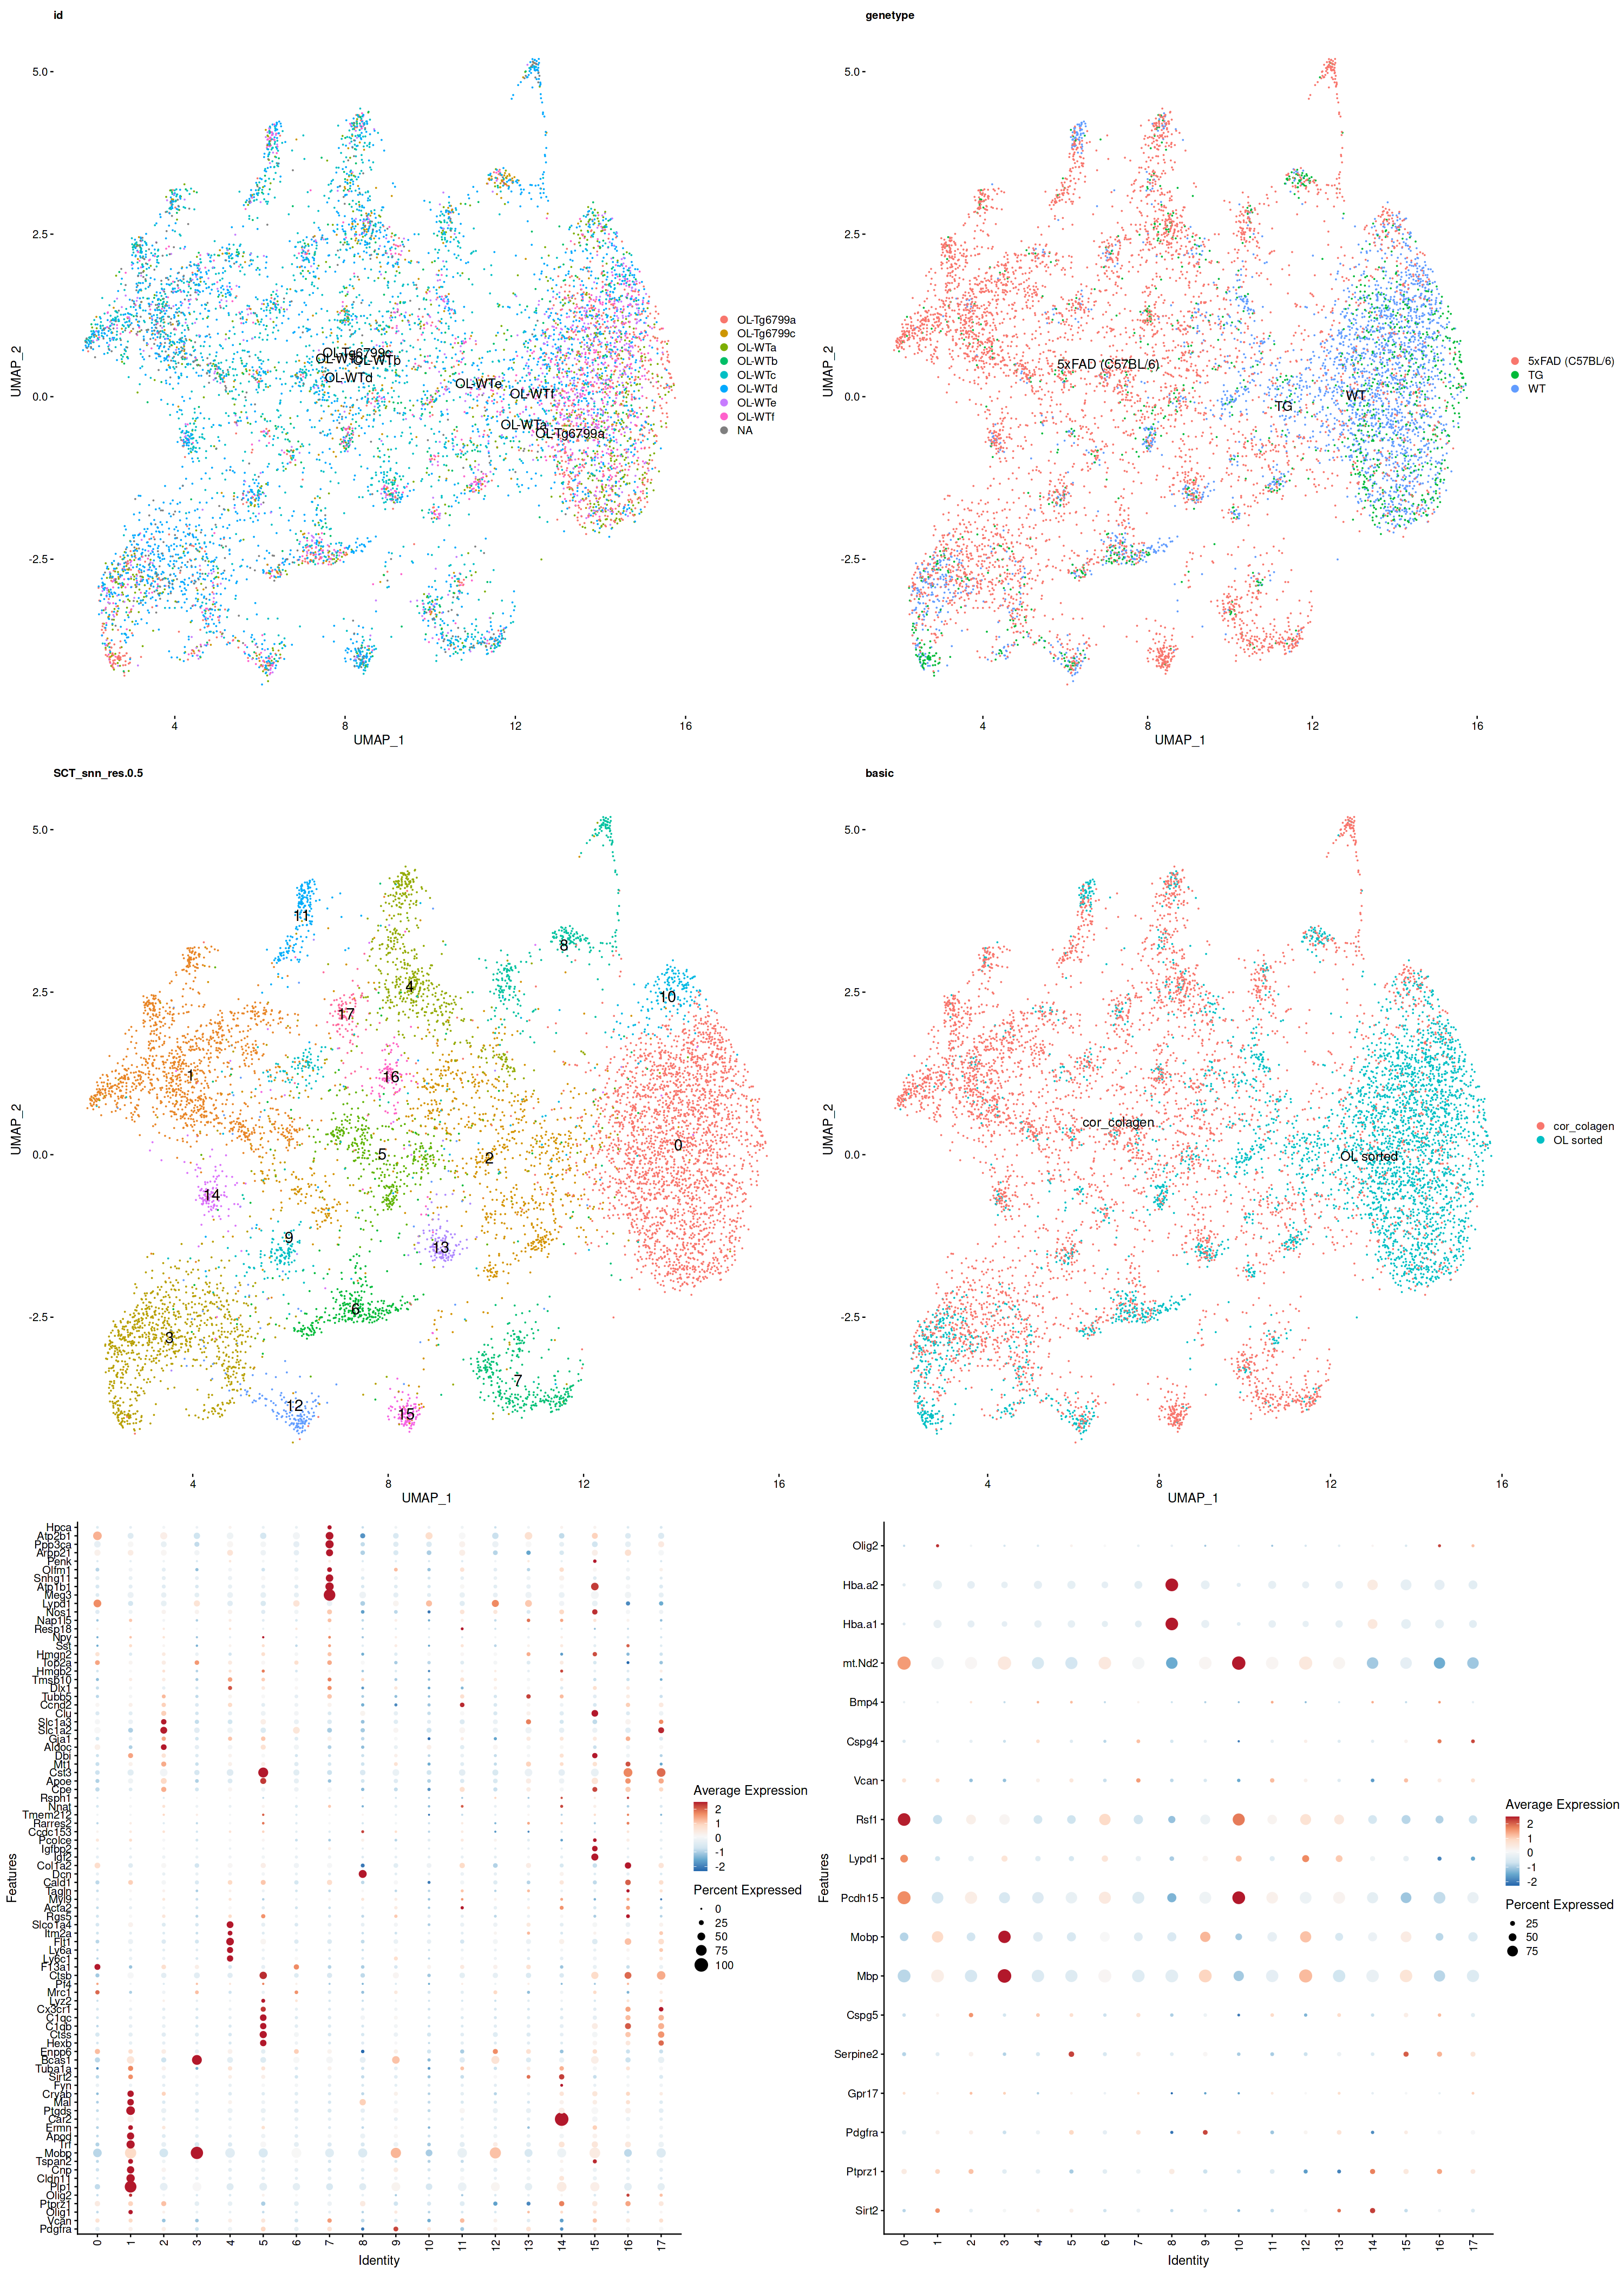

In [15]:

options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(OLs.cor.merge, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.cor.merge, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.cor.merge, group.by = "SCT_snn_res.0.5", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.cor.merge, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(OLs.cor.merge, group.by = "SCT_snn_res.0.5", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.cor.merge, group.by = "SCT_snn_res.0.5", features = c("Sirt2","Ptprz1","Pdgfra","Gpr17","Serpine2","Cspg5",
                                                                             "Mbp","Mobp","Pcdh15", "Lypd1", "Rsf1",
                                                                             "Vcan","Cspg4","Bmp4","mt.Nd2","Hba.a1","Hba.a2","Olig2" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 

# "Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
# "Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    

In [ ]:
# library(SingleR)
# library(Seurat)
# library(ggplot2)
# library(celldex)

#     ref<-MouseRNAseqData()
#     ref_name<-"mouseRNA"
#     exp<-GetAssayData(OLs.merge2, slot = "data", assay = "SCT")

#     rst<-SingleR(test = exp, ref = ref, clusters = OLs.merge.id2$SCT_snn_res.0.3, labels = ref$label.fine)
#     OLs.merge.id2[[ref_name]]<-rst$pruned.labels[match(OLs.merge.id2$SCT_snn_res.0.3, rownames(rst))]

#     DimPlot(OLs.merge.id2, group.by = ref_name, label =T, label.size = 5, pt.size = 0.01,raster=FALSE) 



In [ ]:
OLs.merge1

In [46]:
# PROCESS 1
OLs.merge1 <- merge(OL_sort_[[1]], y= c(OL_sort_[2:length(OL_sort_)]),project = 'merged',merge.data=T)


OLs.merge1 <- OLs.merge1 %>%
                  SCTransform(assay = 'RNA',      
                              new.assay.name = 'SCT',  
                              vars.to.regress = c('percent.mt','nFeature_RNA', 'percent.Hb'),
                              verbose = T)  %>% # normalize data with SCTransform()
                  CellCycleScoring(s.features = intersect(rownames(OLs.merge1),s.gene),  # Perform cell cycle analysis
                                   g2m.features = intersect(rownames(OLs.merge1),g2m.gene),
                                   assay = 'SCT',
                                   set.ident = TRUE) %>%
                  SCTransform(assay = 'RNA',
                              new.assay.name = 'SCT',
                              vars.to.regress = c('percent.mt','nFeature_RNA', 'S.Score', 'G2M.Score', 'percent.Hb'),
                              verbose = T)      

OLs.merge1 <- FindVariableFeatures(OLs.merge1, assay = "SCT",   nfeatures = 1000)

VariableFeatures(OLs.merge1)  <- setdiff(VariableFeatures(OLs.merge1) , grep(c("^mt.|^Hba.a2|^Hba.x|^Hbb.bh1|^Hbb.bh2|^Hbb.bs|^Hbb.bt|^Hbb.y|Hbq1b|Hbs1l|Hbq1a"), VariableFeatures(OLs.merge1) , value =T))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 32040 by 4092

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4092 cells



  |======================================================================| 100%


Found 124 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 32040 genes



  |======================================================================| 100%


Computing corrected count matrix for 32040 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.481516 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, nFeature_RNA, percent.Hb

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 32040 by 4092

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4092 cells



  |======================================================================| 100%


Found 82 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 32040 genes



  |======================================================================| 100%


Computing corrected count matrix for 32040 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 48.2931 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, nFeature_RNA, S.Score, G2M.Score, percent.Hb

Centering data matrix

Set default assay to SCT



In [47]:
pcs <- 1:50
set.seed(1234)
library(harmony)
DefaultAssay(OLs.merge1) <- "SCT"

OLs.merge1.id <- OLs.merge1 %>%
                          RunPCA(verbose = FALSE, assay = "SCT", features = VariableFeatures(OLs.merge1) ) %>%
                          RunHarmony(group.by=c("id"), assay.use = "SCT", dims=pcs) %>% 
                          RunUMAP(reduction = "harmony", umap.method = "umap-learn", assay = "SCT",  dims=pcs) %>%
                          FindNeighbors(reduction = "harmony", dims=pcs, assay = "SCT") %>%
                          FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony converged after 9 iterations

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4092
Number of edges: 204994

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.9232
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4092
Number of edges: 204994

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8861
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4092
Number of edges: 204994

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8582
Number of communities: 9
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4092
Number of edges: 204994

Running Louvain algorithm with multilevel refinement...
Maximum 

In [28]:
OLs.merge1.id

An object of class Seurat 
65530 features across 6980 samples within 2 assays 
Active assay: SCT (32757 features, 991 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, harmony, umap

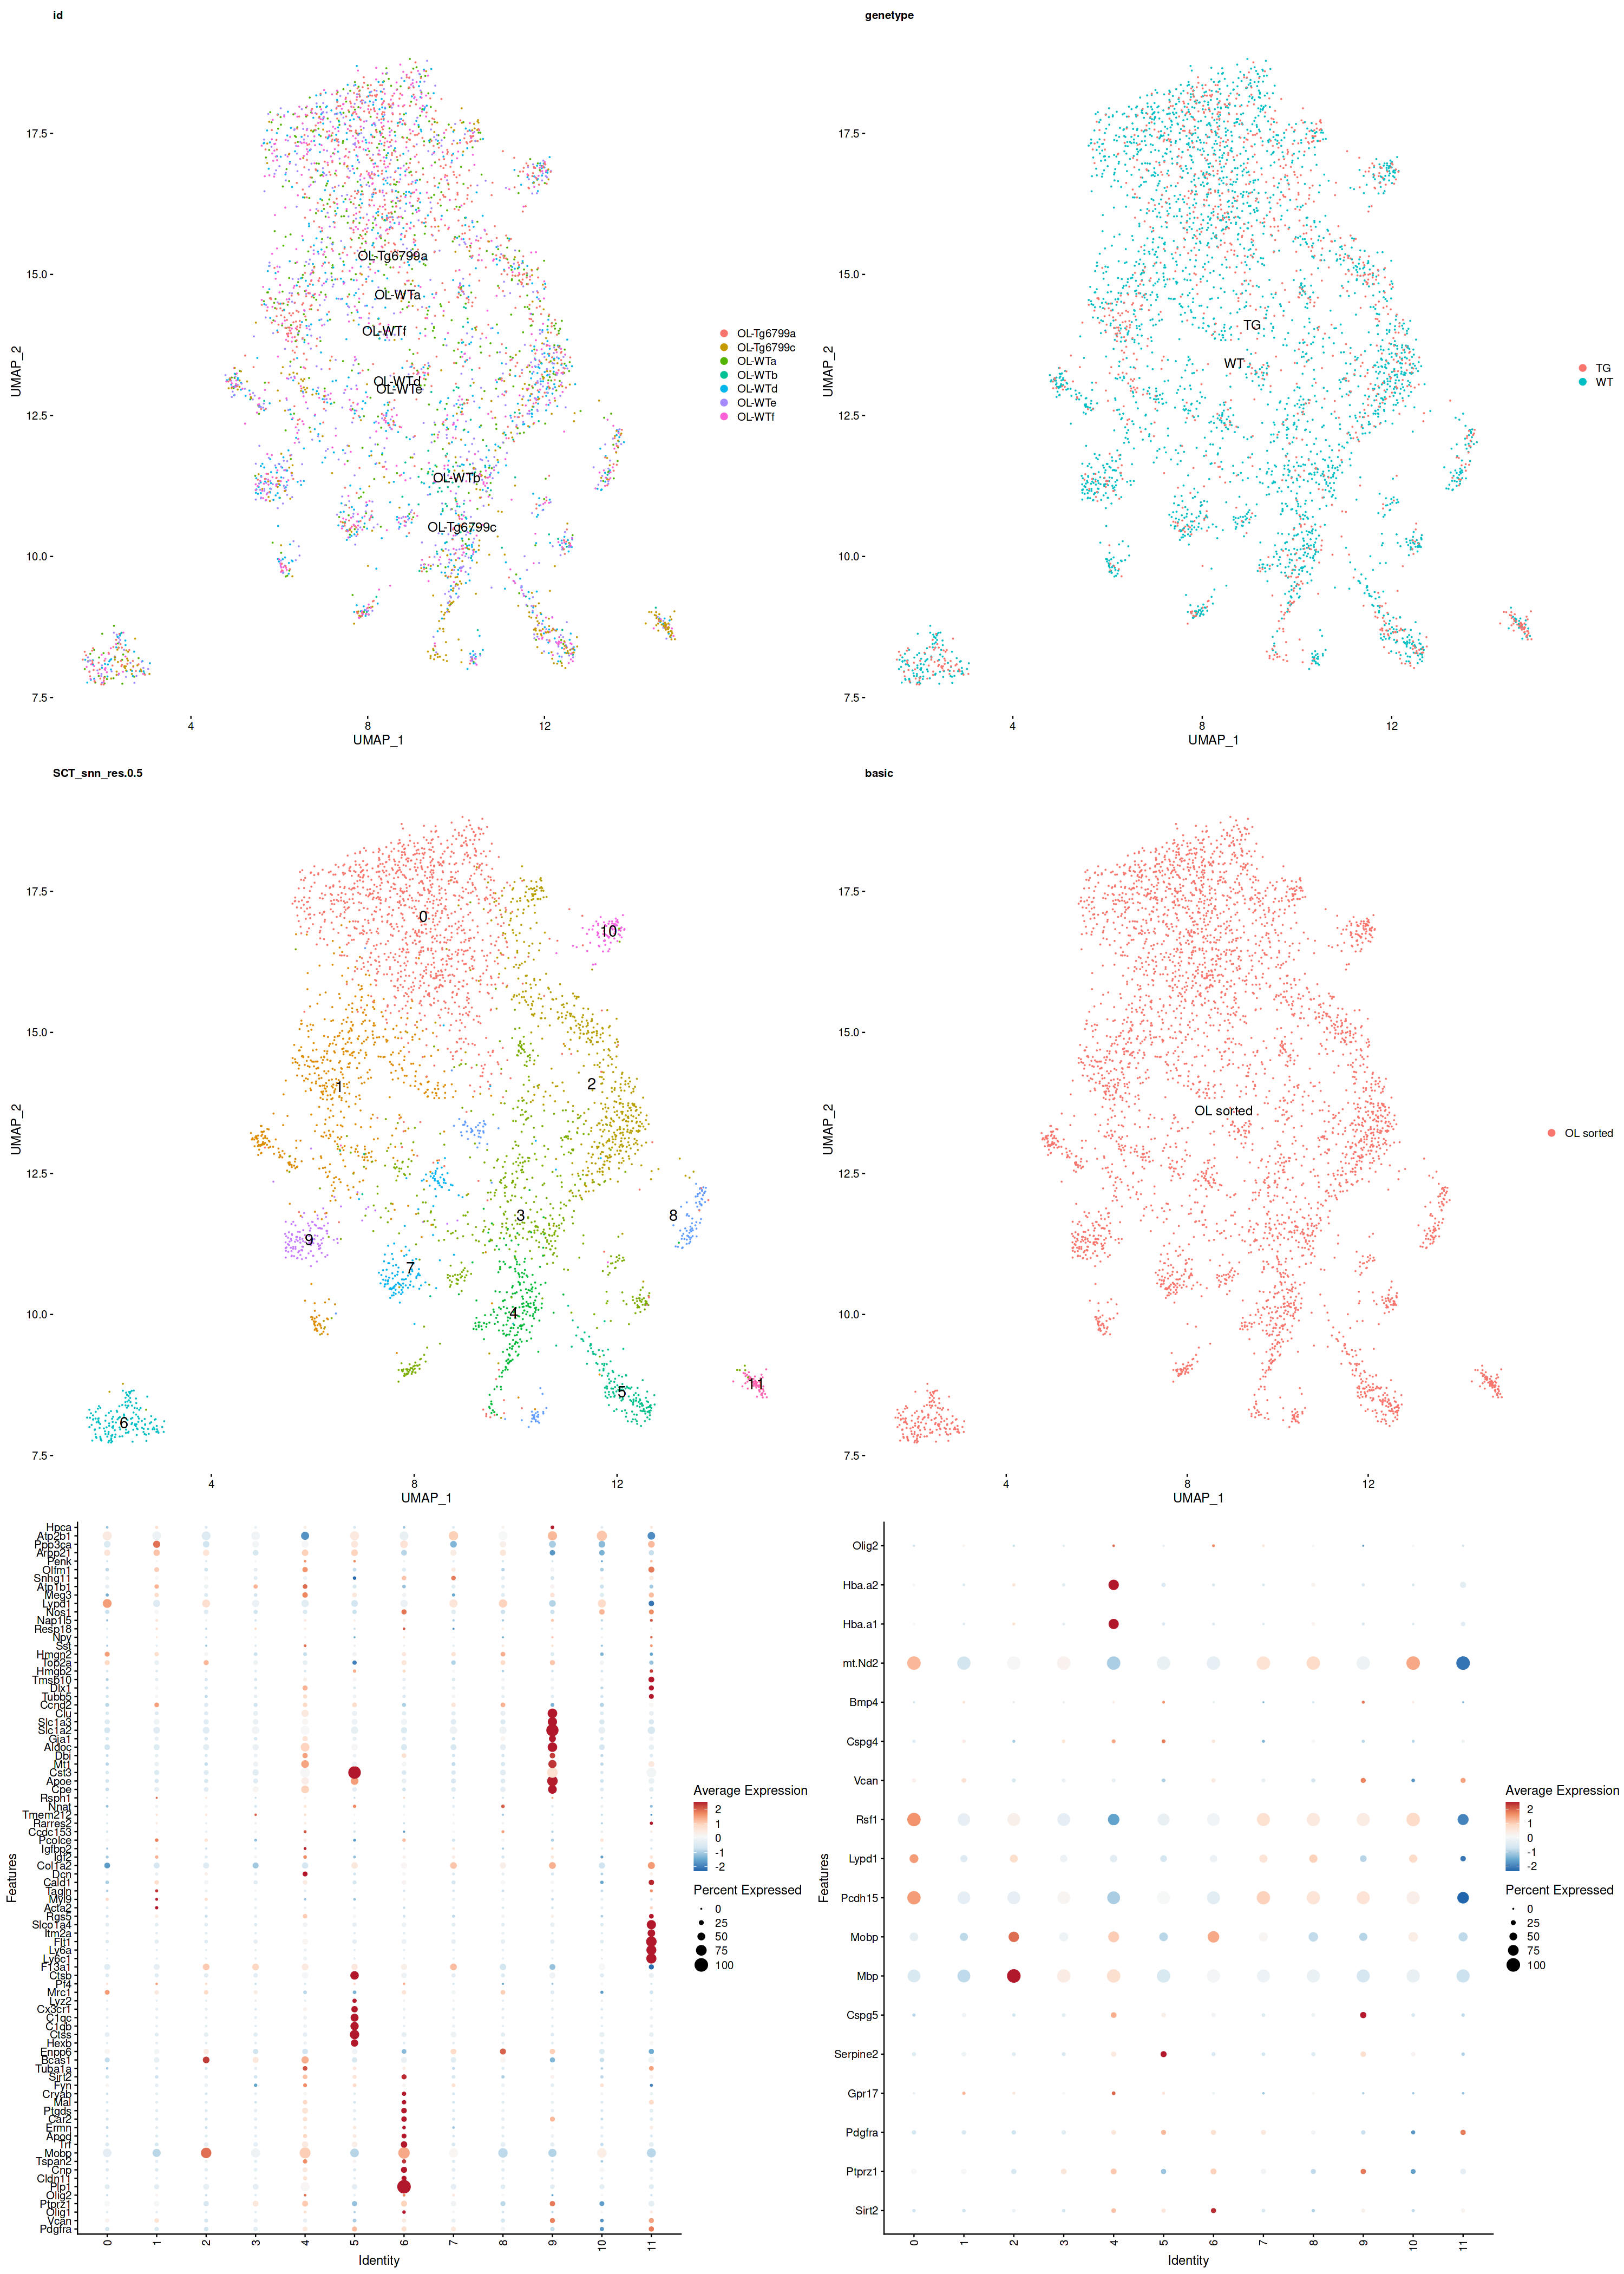

In [54]:

options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge1.id, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge1.id, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge1.id, group.by = "SCT_snn_res.0.5", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge1.id, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(OLs.merge1.id, group.by = "SCT_snn_res.0.5", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge1.id, group.by = "SCT_snn_res.0.5", features = c("Sirt2","Ptprz1","Pdgfra","Gpr17","Serpine2","Cspg5",
                                                                             "Mbp","Mobp","Pcdh15", "Lypd1", "Rsf1",
                                                                             "Vcan","Cspg4","Bmp4","mt.Nd2","Hba.a1","Hba.a2","Olig2" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 

# "Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
# "Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    

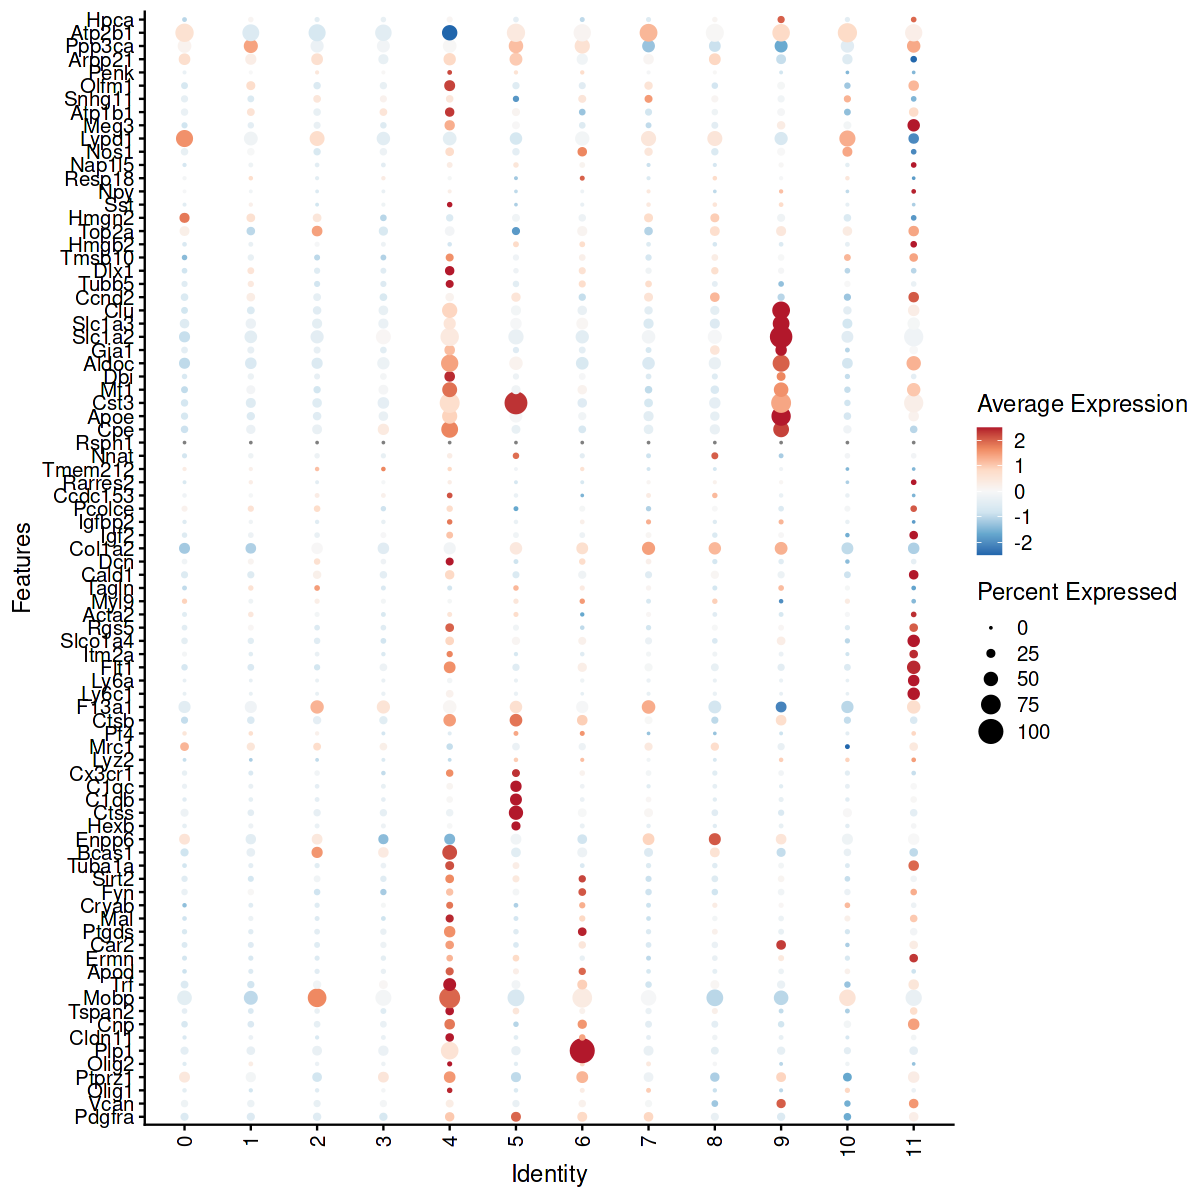

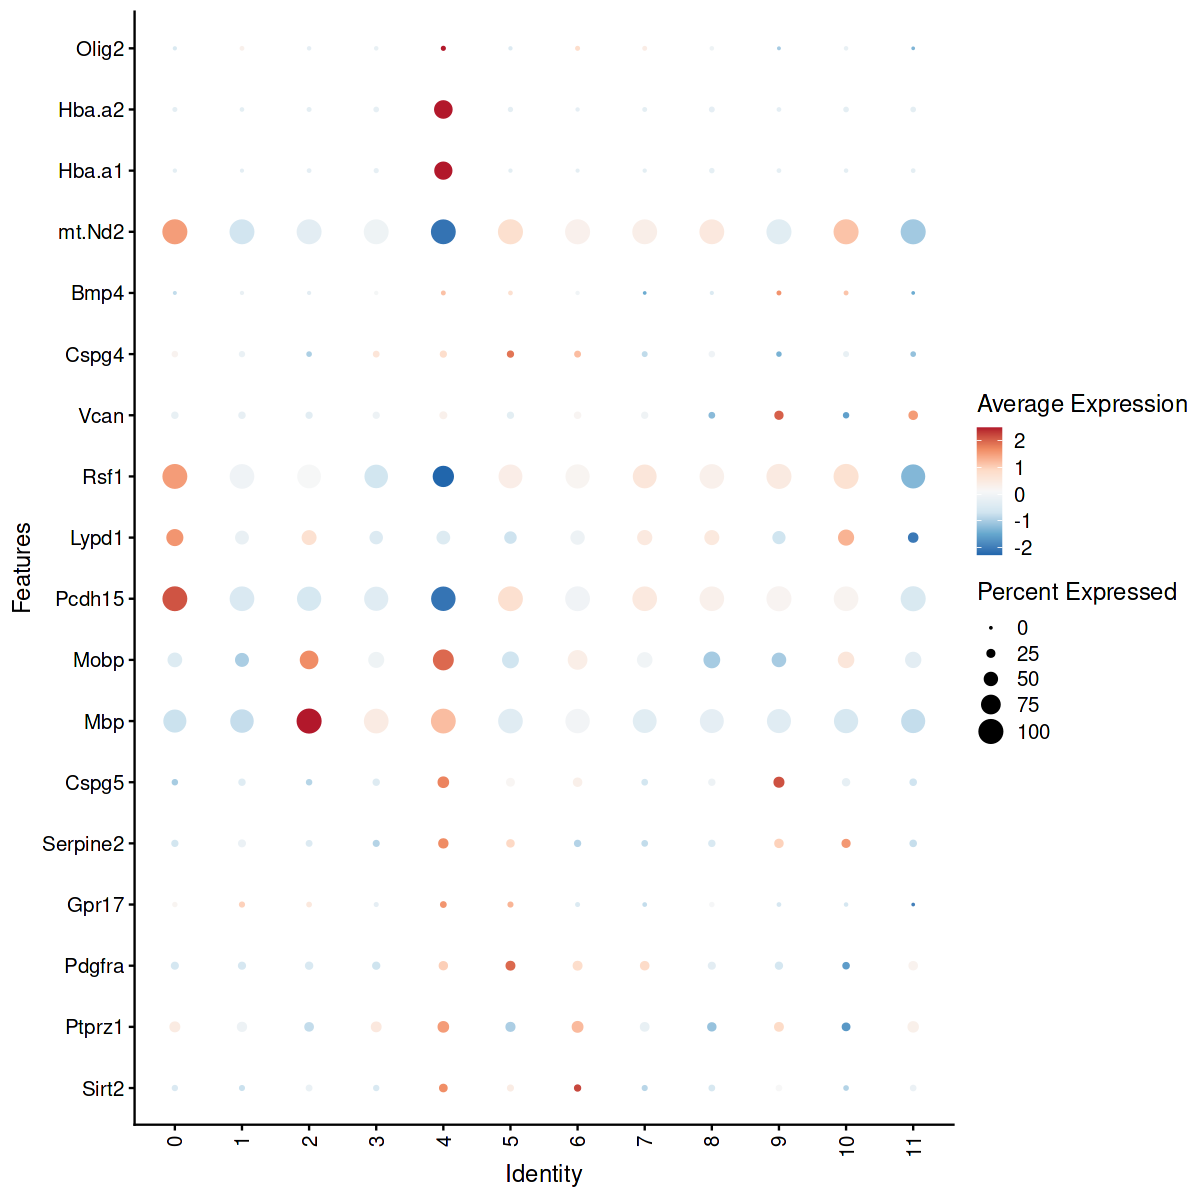

In [56]:
options(repr.plot.width=10, repr.plot.height=10)
DotPlot(OLs.merge1.id[,OLs.merge1.id$genetype=="WT"], group.by = "SCT_snn_res.0.5", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
DotPlot(OLs.merge1.id[,OLs.merge1.id$genetype=="WT"], group.by = "SCT_snn_res.0.5", features = c("Sirt2","Ptprz1","Pdgfra","Gpr17","Serpine2","Cspg5",
                                                                             "Mbp","Mobp","Pcdh15", "Lypd1", "Rsf1",
                                                                             "Vcan","Cspg4","Bmp4","mt.Nd2","Hba.a1","Hba.a2","Olig2" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [50]:
Idents(OLs.merge1.id) <- "SCT_snn_res.0.5" 
OLs.merge1.id.marker <- FindAllMarkers(OLs.merge1.id,  assay = "SCT", logfc.threshold = 0.1,  test.use = "MAST",min.pct = 0.1)


Calculating cluster 0


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster 1


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster 2


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster 3


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster 4


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!

Calculating cluster 5


Done!

Combining coefficients and standard errors

Calculating log-fold chan

In [51]:
mk <- OLs.merge1.id.marker[OLs.merge1.id.marker$cluster == "0",]
mk <- mk %>% arrange(desc(avg_log2FC)) 
head(mk,20)
print(noquote(paste0(mk$gene[1:30],",")))

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene    
Gm44682  5.616998e-65 0.5530337  0.669 0.426 1.799686e-60 0       Gm44682 
Olfr1163 6.945033e-71 0.5451543  0.752 0.554 2.225189e-66 0       Olfr1163
Gm50384  1.106568e-67 0.5406558  0.748 0.521 3.545445e-63 0       Gm50384 
Gm5432   2.589703e-73 0.5290361  0.800 0.559 8.297409e-69 0       Gm5432  
Ccnt1    1.256185e-59 0.5194585  0.691 0.472 4.024816e-55 0       Ccnt1   
Itgb6    8.029377e-82 0.5175001  0.962 0.872 2.572612e-77 0       Itgb6   
Fam91a1  1.132013e-63 0.5123135  0.738 0.528 3.626968e-59 0       Fam91a1 
Olfr597  2.033466e-78 0.5085146  0.906 0.728 6.515225e-74 0       Olfr597 
Zdbf2    4.633145e-74 0.5041478  0.901 0.753 1.484460e-69 0       Zdbf2   
Corin    1.067545e-59 0.5027381  0.598 0.389 3.420415e-55 0       Corin   
Trim24   1.356483e-73 0.5016991  0.818 0.608 4.346172e-69 0       Trim24  
Rd3      1.836749e-56 0.4981128  0.612 0.400 5.884943e-52 0       Rd3     
Olfr782  4.301170e-66 0.4956688  0.782 0.581 1.378095e-61 0       Olfr782 
Dnttip2  1.295834e-75 0.4948974  0.952 0.822 4.151853e-71 0       Dnttip2 
Rsf1     2.517695e-83 0.4931428  0.986 0.920 8.066695e-79 0       Rsf1    
Gm40552  1.161239e-64 0.4855464  0.764 0.543 3.720611e-60 0       Gm40552 
Gm32591  2.385384e-57 0.4796451  0.701 0.479 7.642771e-53 0       Gm32591 
Gbp7     3.634647e-72 0.4778799  0.932 0.776 1.164541e-67 0       Gbp7    
Hoxa11   2.414994e-63 0.4766340  0.754 0.550 7.737641e-59 0       Hoxa11  
Scyl2    3.748875e-62 0.4717110  0.806 0.629 1.201140e-57 0       Scyl2

 [1] Gm44682,        Olfr1163,       Gm50384,        Gm5432,        
 [5] Ccnt1,          Itgb6,          Fam91a1,        Olfr597,       
 [9] Zdbf2,          Corin,          Trim24,         Rd3,           
[13] Olfr782,        Dnttip2,        Rsf1,           Gm40552,       
[17] Gm32591,        Gbp7,           Hoxa11,         Scyl2,         
[21] Olfr620,        Krtap14,        Gm34354,        Tas2r131,      
[25] Olfr735,        X4930555M17Rik, Parpbp,         Vmn1r30,       
[29] Olfr560,        Igkv1.122,     


In [26]:
OLs.merge.id2.filt <- OLs.merge.id2[,!grepl("^6|^8|^9", OLs.merge.id2$SCT_snn_res.0.1)]

ERROR: Error in eval(expr, envir, enclos): object 'OLs.merge.id2' not found


In [25]:

options(repr.plot.width=10, repr.plot.height = 10)
DimPlot(OLs.merge.id2.filt, group.by = "SCT_snn_res.0.7", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
DotPlot(OLs.merge.id2.filt, group.by = "SCT_snn_res.0.7", features = c("Pdgfra","Cspg4","Gpr17","Vcan", "Serpine2","Olig2", "Pcdh15",
                                                                       "Fyn", "Sirt2","Bmp4","Tnr","Enpp6", "Neu4","Cd9", 
                                                                             "Mbp","Mobp", "Plp1", "Opalin", "Ptgds", "Mal" 
                                                                             ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ERROR: Error in is(x, "classRepresentation"): object 'OLs.merge.id2.filt' not found


In [ ]:
OLs.merge.id2.filt <- OLs.merge.id2[,grepl("^8|^2|1$", OLs.merge.id2$SCT_snn_res.0.7)]
options(repr.plot.width=10, repr.plot.height = 10)
DimPlot(OLs.merge.id2.filt, group.by = "SCT_snn_res.0.7", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
DotPlot(OLs.merge.id2.filt, group.by = "SCT_snn_res.0.7", features = c("Pdgfra","Cspg4","Gpr17","Vcan", "Serpine2","Olig2",
                                                                       "Fyn", "Sirt2","Bmp4","Tnr","Enpp6", "Neu4","Cd9", 
                                                                             "Mbp","Mobp", "Plp1", "Opalin", "Ptgds", "Mal", "Pcdh15" 
                                                                             ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
options(repr.plot.width = 40, repr.plot.height = 30) 
library(Nebulosa)
plot_density(OLs.merge.id2.filt, size = .1,features = c(oligo.mark[1:15]) , method = c("wkde"), pal = "inferno", adjust = 0.5)
options(repr.plot.width = 40, repr.plot.height = 30) 
plot_density(OLs.merge.id2.filt, size = .1,features = c(oligo.mark[16:30]) , method = c("wkde"), pal = "inferno", adjust = 0.5)

In [ ]:
OLs.merge.id2.filt <- OLs.merge.id2[, !grepl("^4|^5|^8", OLs.merge.id2$SCT_snn_res.0.3)]

In [ ]:
# silhouette metric
library(cluster, quietly = TRUE)

dist.matrix <- dist(x = Embeddings(object = OLs.merge.id2[["umap"]])[, 1:2])
sil <- list()
for(i in seq(0.1,1,0.1)){
    clusters <- unlist(OLs.merge.id2[[paste0("SCT_snn_res.",i)]])
    sil[[paste0("SCT_snn_res.",i)]] <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
}


for(j in seq(0.1,1,0.1)){
    print(j)
    print(mean(sil[[paste0("SCT_snn_res.",j)]][,3]))
    print(median(sil[[paste0("SCT_snn_res.",j)]][,3]))
    
    
}

In [ ]:
Idents(OLs.merge.id2) <- "SCT_snn_res.0.7" 
OLs.merge.id2.marker <- FindAllMarkers(OLs.merge.id2,  assay = "SCT", logfc.threshold = 0.1,  test.use = "MAST",min.pct = 0.1)


In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)
DimPlot(OLs.merge.id2, group.by = "SCT_snn_res.0.7", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
DotPlot(OLs.merge.id2, group.by = "SCT_snn_res.0.7", features = c("Bmp4"), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

DimPlot(OLs.merge.id2, reduction = "umap", cells.highlight = colnames(OLs.merge.id2[,OLs.merge.id2$SCT_snn_res.0.7 == "4"]), group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())

In [ ]:
mk <- OLs.merge.id2.marker[OLs.merge.id2.marker$cluster == "0",]
mk <- mk %>% arrange(desc(avg_log2FC)) 
head(mk,20)
print(noquote(paste0(mk$gene[1:30],",")))

celltype <- c()
celltype[1] <- "OPC 0" # 0 
celltype[2] <- "Oligo 1" # 1 
celltype[3] <- "Oligo 2" # 2 
celltype[4] <- "MT/poly 3"# 3
celltype[5] <- "Neuron/COP 4"#4 
celltype[6] <- "Astrocyte 5"# 5 
celltype[7] <- "Oligo 6"# 6
celltype[8] <- "OPC 0"# 7
celltype[9] <- "Micro 8 "# 8
celltype[10] <- "Hbb/Poly/fibro 9"# 9
celltype[11] <- "Endo 10"# 10
celltype[12] <- "Astro/Oligo/neuron/opc/vlmc 11"# 11



Idents(OLs.merge.id2) <- "SCT_snn_res.0.7"
# names(celltype) <- levels(OLs.merge.id.2.10)
names(celltype) <- names(table(OLs.merge.id2$SCT_snn_res.0.7))
OLs.merge.id2 <- RenameIdents(OLs.merge.id2, celltype)
OLs.merge.id2$celltype <- Idents(OLs.merge.id2)

# p7 <- list()
# p7[[1]] <- DimPlot(OLs.merge.id.2.10.sub, group.by = "celltype", label =T, label.size = 7, pt.size = 0.01,raster=FALSE) + 
#            theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position="",  axis.line = element_blank())
# p7[[2]] <- DimPlot(OLs.merge.id.2.10.sub, group.by = "SCT_snn_res.0.6", label =T, label.size = 7, pt.size = 0.01,raster=FALSE) + 
#            theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
# p7[[3]] <- DotPlot(OLs.merge.id.2.10.sub, group.by = "celltype", 
#                    features = unique(c("Mobp","Fth1","Mbp","Pcdh15","Pdgfra","Fyn","Sirt2","Bmp4","Cspg4","Slc15a2","Neu4","Mrc1")), assay="SCT" , cols ="RdBu") + coord_flip() +
#                     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
# options(repr.plot.width = 20, repr.plot.height = 7) 

# plot_grid(p7[[1]], p7[[2]], p7[[3]], ncol =3)

In [ ]:
OLs.merge.id2.filt <- OLs.merge.id2[, !grepl("^4|^5|^7|^8", OLs.merge.id2$SCT_snn_res.0.3)]

In [ ]:
##### trajectory 

sce.obj <- as.SingleCellExperiment(OLs.merge.id2.filt, assay = "SCT")
library(slingshot)

sling.obj <-slingshot(sce.obj, reducedDim = 'UMAP', clusterLabels = colData(sce.obj)$SCT_snn_res.0.3, start.clus = "6")

# cellsSlingshot <-slingshot(Embeddings(CD4T_flt, "umap"), clusterLabels = CD4T_flt$CD4T_new, start.clus = "a. T naive type 1")

lin <- getLineages(sling.obj, reducedDim = 'UMAP', clusterLabels = sce.obj$SCT_snn_res.0.3, start.clus = "6")
crv <- getCurves(lin)
SlingshotDataSet(crv)

# embedded <- embedCurves(cellsSlingshot, "UMAP")
# embedded <- slingCurves(embedded)#[[1]] # only 1 path.
# embedded_ <- data.frame(embedded$s[embedded$ord,])


In [ ]:
library(dittoSeq)
options(repr.plot.width = 8, repr.plot.height = 10) 

dittoDimPlot(sling.obj, var = "SCT_snn_res.0.3", 
                   size=0.25,
                   theme= theme_void(),
                   reduction.use="UMAP",
                   trajectory.arrow.size = 0.2,
                   add.trajectory.curves = slingCurves(sling.obj)[c(1,2,3)],
                   colors = c(1,2,15,4,20,25,30,35,40),                     
                   legend.show = T,
                   main = "Start cluster : type 1",
                   sub = "single RNA inference of MTOPC3") 

In [ ]:
# crv <- getCurves(lin)
weight <- slingCurveWeights(sling.obj)
pseudotime <- slingPseudotime(sling.obj, na = TRUE)

# slingBranchGraph(cellsSlingshot)
colData(sling.obj)[,colnames(weight)] <- weight
colData(sling.obj)[,c("pseudo1","pseudo2","pseudo3")] <- pseudotime

n <- 1


sling.obj$lineage1 <- "Oligo lineage"
sling.obj$lineage1[(weight[,1] == 0) & (weight[,2] == 0) & (weight[,2] == 0)] <- "None"
sling.obj$lineage1[(weight[,1] > 0) | (weight[,2] > 0) | (weight[,3] > 0)] <- "Common"
sling.obj$lineage1[(weight[,1] >= n) & (weight[,2] < n) & (weight[,3] < n)]<- "Trajectory 1"
sling.obj$lineage1[(weight[,1] < n) & (weight[,2] >= n) & (weight[,3] < n)]<- "Trajectory 2"
sling.obj$lineage1[(weight[,1] < n) & (weight[,2] < n) & (weight[,3] >= n)]<- "Trajectory 3"

# seuart.obj <-as.Seurat(sling.obj)
# Idents(seuart.obj) <- "celltype2"

cols_ <- RColorBrewer::brewer.pal(n = 10, name = "Set1")

p10_1 <- dittoDimPlot(sling.obj, reduction.use = "UMAP", var = "lineage1"
                # colors  = c("lightgray", dittoColors()[10:20])
                # cols = c(dittoColors()[1],brewer.pal(3,"Paired")[2],rep("lightgray",3),brewer.pal(3,"Paired")[3]),
                ) +
  theme_void() + 
  theme(legend.position = "right",  axis.title = element_blank(), 
        plot.title = element_text(size = 14, face = "bold",hjust = 0))+
  ggtitle(paste0("Trajectory 1 groups : ",
                 comma(length(colnames(subset(OLs.merge.id.2.10.sub,subset=lineage1=="Trajectory 1"))),format="d"),
                 " cells, Trajectory 2 groups : ",
                 comma(length(colnames(subset(OLs.merge.id.2.10.sub,subset=lineage1=="Trajectory 2"))),format="d"),
                 " cells in Bmp4 activated groups "))






options(repr.plot.width = 10, repr.plot.height = 6) 
plot_grid(p10_1)

In [ ]:
n <- 1

sling.obj$lineage2 <- sling.obj$lineage1
for(i in c("Trajectory 1", "Trajectory 2", "Trajectory 3")){
    for( j in c("WT","TG")){
        type <- paste0(i,"-",j)
        sling.obj$lineage2[grepl(i, sling.obj$lineage1) & sling.obj$genetype == j] <- type
        sling.obj[[type]] <- NA
        sling.obj[[type]][grep(type, sling.obj$lineage2)] <- sling.obj$pseudo1[grep(type, sling.obj$lineage2)]

    }
    
}

In [ ]:
# c(cellsSlingshot[["Trajectory 1-TG"]]>0)/(cellsSlingshot[["Trajectory 1-WT"]]>0)

ival <- 3
sling.obj[[paste0("pseudo_int",ival)]] <- '1. 0'


for(i in 1:length(seq(0,20, ival))){
    # tr1[] <- sum(cellsSlingshot[["Trajectory 1-TG"]] > i & cellsSlingshot[["Trajectory 1-TG"]] <= i+5) / sum(cellsSlingshot[["Trajectory 1-WT"]] > i & cellsSlingshot[["Trajectory 1-WT"]] <= i+5)
    # print(paste0("Trajectory 1 -- ", as.character(i), " " , as.character(i+5), " : ",  a))
    # tr2[] <- sum(cellsSlingshot[["Trajectory 2-TG"]] > i & cellsSlingshot[["Trajectory 2-TG"]] <= i+5) / sum(cellsSlingshot[["Trajectory 2-WT"]] > i & cellsSlingshot[["Trajectory 2-WT"]] <= i+5)
    # print(paste0("Trajectory 2 -- ", as.character(i), " " , as.character(i+5), " : ",  b))
    
    Min <- i*ival
    Max <- (i+1)*ival
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 1-WT"]] > Min & sling.obj[["Trajectory 1-WT"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 1-TG"]] > Min & sling.obj[["Trajectory 1-TG"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 2-WT"]] > Min & sling.obj[["Trajectory 2-WT"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)
    sling.obj[[paste0("pseudo_int",ival)]][which(sling.obj[["Trajectory 2-TG"]] > Min & sling.obj[["Trajectory 2-TG"]] <= Max)] <- paste0(i+1, ". ", Min, " ~ ", Max)    

}

options(repr.plot.width = 10, repr.plot.height = 10) 

p1 <- dittoBarPlot(sling.obj[,sling.obj$lineage1=="Trajectory 1"], var = "genetype", group.by = paste0("pseudo_int",ival), main = "Trajectory 1")

p2 <- dittoBarPlot(sling.obj[,sling.obj$lineage1=="Trajectory 2"], var = "genetype", group.by = paste0("pseudo_int",ival), main = "Trajectory 2")
# dittoBarPlot(cellsSlingshot, "genetype", group.by = "pseudo2_int5")

plot_grid(p1,p2, ncol=1)

In [ ]:
# options(repr.plot.width = 10, repr.plot.height = 10)

# DotPlot(OLs.merge.id2.filt[,OLs.merge.id2.filt$genetype =="TG"], group.by = "SCT_snn_res.0.2", features = c("C4b",
# "Ttr",
# "B2m",
# "Stmn1",
# "Serpina3n",
# "Ddx3y",
# "Sgk1",
# "Hspa8", "Bmp4")
# , assay="SCT" , cols ="RdBu") + coord_flip() + 
#            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


In [ ]:
OLs.merge.id2

In [ ]:
OLs.merge.id2.filt <- OLs.merge.id2[, !grepl("^4|^5|^6|^8|^10", OLs.merge.id2$SCT_snn_res.0.3)]

In [ ]:
options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge.id2.filt, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge.id2.filt, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge.id2.filt, group.by = "SCT_snn_res.0.3", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge.id2.filt, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(OLs.merge.id2.filt, group.by = "SCT_snn_res.0.3", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge.id2.filt, group.by = "SCT_snn_res.0.3", features = c("Sirt2","Ptprz1","Pdgfra","Serpine2","Cspg5","Vcan","Cspg4","Bmp4","Pcdh15","mt.Nd2","Hba.a1","Ralgps1" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 

In [ ]:
options(repr.plot.width = 40, repr.plot.height = 30) 
library(Nebulosa)
plot_density(OLs.merge.id2.filt, size = .1,features = c(oligo.mark[1:15]) , method = c("wkde"), pal = "inferno", adjust = 0.5)
options(repr.plot.width = 40, repr.plot.height = 30) 
plot_density(OLs.merge.id2.filt, size = .1,features = c(oligo.mark[16:30]) , method = c("wkde"), pal = "inferno", adjust = 0.5)

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 10)

VlnPlot(OLs.merge.id2, features = c("percent.mt", "percent.Hb"), group.by = "id", assay="RNA")
DefaultAssay(OLs.merge.id2) <- "SCT"

FeaturePlot(OLs.merge.id2, features = c("percent.mt", "percent.Hb"))




In [ ]:
OLs.merge3.genetype

In [ ]:
data.list2 <- sapply(OL_sort_, FUN = function(x) {
     
                x %>% 
                  SCTransform(assay = 'RNA',      
                              new.assay.name = 'SCT',  
                              vars.to.regress = c('percent.mt','nFeature_RNA','percent.Hb'),
                              verbose = T)  

    })

OLs.merge.features <- SelectIntegrationFeatures(object.list = data.list2, nfeatures = 1000)
OLs.merge.features <- setdiff(OLs.merge.features, grep(c("^mt-|^Hba1|^Hba2|^Hbb|^Hbd|^Hbg1|^Hbg2|^Hbm|^Hbq1"), OLs.merge.features, value =T))

OLs.merge3 <- merge(data.list2[[1]], y= c(data.list2[2:length(data.list2)]),project = 'merged',merge.data=T)

VariableFeatures(OLs.merge3) <- OLs.merge.features

pcs <- 10
set.seed(1234)
library(harmony)
DefaultAssay(OLs.merge) <- "SCT"

In [ ]:
pcs <- 2:20

OLs.merge3.genetype <-OLs.merge3 %>%
          RunPCA(verbose = FALSE, features = VariableFeatures(OLs.merge3)) %>%
          RunHarmony(group.by=c("genetype"), assay.use = "SCT", dims=pcs) %>% 
          RunUMAP(reduction = "harmony", umap.method = "umap-learn", dims=pcs) %>%
          FindNeighbors(reduction = "harmony", dims=pcs) %>%
          FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)
options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge3.genetype, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge3.genetype, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge3.genetype, group.by = "SCT_snn_res.0.5", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge3.genetype, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(OLs.merge3.genetype, group.by = "SCT_snn_res.0.5", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge3.genetype, group.by = "SCT_snn_res.0.5", features = c("Sirt2","Ptprz1","Pdgfra","Serpine2","Cspg5","Vcan","Cspg4","Bmp4" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 

# "Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
# "Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    

options(repr.plot.width = 40, repr.plot.height = 30) 
library(Nebulosa)
plot_density(OLs.merge.genetype, size = .1,features = c(oligo.mark[1:15]) , method = c("wkde"), pal = "inferno", adjust = 0.5)
options(repr.plot.width = 40, repr.plot.height = 30) 
plot_density(OLs.merge.genetype, size = .1,features = c(oligo.mark[16:30]) , method = c("wkde"), pal = "inferno", adjust = 0.5)

In [ ]:
pcs <- 2:10

OLs.merge3.genetype <-OLs.merge3 %>%
          RunPCA(verbose = FALSE, features = VariableFeatures(OLs.merge3)) %>%
          RunHarmony(group.by=c("genetype"), assay.use = "SCT", dims=pcs) %>% 
          RunUMAP(reduction = "harmony", umap.method = "umap-learn", dims=pcs) %>%
          FindNeighbors(reduction = "harmony", dims=pcs) %>%
          FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)
options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge3.genetype, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge3.genetype, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge3.genetype, group.by = "SCT_snn_res.0.5", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge3.genetype, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(OLs.merge3.genetype, group.by = "SCT_snn_res.0.5", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge3.genetype, group.by = "SCT_snn_res.0.5", features = c("Sirt2","Ptprz1","Pdgfra","Serpine2","Cspg5","Vcan","Cspg4","Bmp4" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 

# "Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
# "Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    

options(repr.plot.width = 40, repr.plot.height = 30) 
library(Nebulosa)
plot_density(OLs.merge.genetype, size = .1,features = c(oligo.mark[1:15]) , method = c("wkde"), pal = "inferno", adjust = 0.5)
options(repr.plot.width = 40, repr.plot.height = 30) 
plot_density(OLs.merge.genetype, size = .1,features = c(oligo.mark[16:30]) , method = c("wkde"), pal = "inferno", adjust = 0.5)

In [ ]:
pcs <- 1:20

OLs.merge3.genetype <-OLs.merge3 %>%
          RunPCA(verbose = FALSE, features = VariableFeatures(OLs.merge3)) %>%
          RunHarmony(group.by=c("genetype"), assay.use = "SCT", dims=pcs) %>% 
          RunUMAP(reduction = "harmony", umap.method = "umap-learn", dims=pcs) %>%
          FindNeighbors(reduction = "harmony", dims=pcs) %>%
          FindClusters(resolution = seq(0.1,1,0.1), algorithm = 2)
options(repr.plot.width = 25, repr.plot.height = 35)
p1 <- list()
p1[[1]] <- DimPlot(OLs.merge.genetype, reduction = "umap", group.by = "id", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[2]] <- DimPlot(OLs.merge.genetype, group.by = "genetype", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), axis.line = element_blank())
p1[[4]] <- DimPlot(OLs.merge.genetype, group.by = "SCT_snn_res.0.5", label =T, label.size = 6, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0), legend.position = "none", axis.line = element_blank())
p1[[5]] <- DimPlot(OLs.merge.genetype, group.by = "basic", label =T, label.size = 5, pt.size = 0.01,raster=FALSE) + 
           theme(plot.title = element_text(size = 12, face = "bold",hjust = 0),  axis.line = element_blank())
p1[[6]] <- DotPlot(OLs.merge.genetype, group.by = "SCT_snn_res.0.5", features = unique(GSE118918.marker), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
p1[[7]] <- DotPlot(OLs.merge.genetype, group.by = "SCT_snn_res.0.5", features = c("Sirt2","Ptprz1","Pdgfra","Serpine2","Cspg5","Vcan","Cspg4","Bmp4" ), assay="SCT" , cols ="RdBu") + coord_flip() + 
           theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot_grid(p1[[1]],p1[[2]], p1[[4]], p1[[5]], p1[[6]], p1[[7]], ncol=2) 

# "Ccnd2","Tubb5","Dlx1","Tmsb10","Tuba1a", #NSC
# "Hmgb2","Top2a","Hmgn2","Tubb5","H2afz", # NSC    

options(repr.plot.width = 40, repr.plot.height = 30) 
library(Nebulosa)
plot_density(OLs.merge.genetype, size = .1,features = c(oligo.mark[1:15]) , method = c("wkde"), pal = "inferno", adjust = 0.5)
options(repr.plot.width = 40, repr.plot.height = 30) 
plot_density(OLs.merge.genetype, size = .1,features = c(oligo.mark[16:30]) , method = c("wkde"), pal = "inferno", adjust = 0.5)